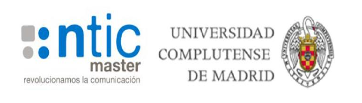

# NLP Deceitful Review Detection on e-Commerce and Social Media (2020)

This work is part of the final work to the <b>Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020.</b>



Authors: Marta Roig Atienza, Alejandra Lloret Calvo, Juan Pablo Guerrero Ortiz, Laura Débora Fernández Basquero, Ainhoa Rodrigo Bolea, Cristian Fernando Rodríguez Saldarriaga


# New Predictions NLP

<b> Libraries </b> 

In [2]:
# Varios
# ------------------------------------------------------------------------------
import os.path
import logging
from sinfo import sinfo
import re
import string
import math

# Tratamiento de textos
# ------------------------------------------------------------------------------
from scipy import sparse
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(["I've", "I'm", "I"])
from textblob import TextBlob

# Tratamiento de datos
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ------------------------------------------------------------------------------
import pickle
# ----------- gensim ----------
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.utils import simple_preprocess, lemmatize
from gensim.models import Word2Vec
from gensim.sklearn_api import TfIdfTransformer
from gensim.test.utils import common_corpus, common_dictionary
from gensim import models, corpora, matutils

# ----------- sklearn ----------
from sklearn import model_selection, datasets
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ----------- keras ----------
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import cufflinks
import plotly.express as px
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# EDA
# ------------------------------------------------------------------------------
# LIBRARIES 
import en_core_web_sm
# Spacy lemmatization librariesimport en_core_web_sm
nlp = en_core_web_sm.load()
#TextBlob lemmatization libraries
from textblob import TextBlob, Word

# Gensim lemmatization libraries. It is necessary to install gensim and pattern
import pattern
from pattern.en import lemma, lexeme
from tabulate import tabulate
import emoji

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Definition Functions

### Loading Data 

In [6]:
def read_data(filename, sep=','):
    """
        filename: path dataSet
        sep: separator text     

        return: data
    """
    data = pd.read_csv(filename, sep=sep, encoding='utf-8')
    return data

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

def load_model_vector(path_name_file):
    # Load from file
    with open(path_name_file, 'rb') as fin:
        vectorizer, model = pickle.load(fin)
    
    return vectorizer, model

### Feature Vector

In [7]:
def feature_vector(type_vect, x_test, text_review, set_columns =[], embedding_model = 0):
    """
        type_vect: vector type
            1: TF-IDF, CountVectorizer, N-Grams
            2: Word2vec, Glove
        x_test — samples
        text_review: text to be converted into a set of numbers (vectorization)
        set_columns: different columns to be added to the model
        embedding_model: embedding pre-trained model
       
        return vectorized representation of each type
    """
    # TF-IDF, CountVect, Ngrams models
    if type_vect == 1:
        
        # Transform
        vect_new = vectorizer.transform(x_test[text_review])

        # Validation add more features
        if len(set_columns) == 0:
            x_test_vector = vect_new
        else:
            # csr_matrix -> Compressed Sparse Row matrix
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # sparse.hstack -> Stack sparse matrices horizontally (column wise)
            x_test_vector = sparse.hstack([csr_mxTest, vect_new], format="csr")
            
        return x_test_vector
    
    # Embedding models
    elif type_vect == 2:
    
        # Apply word_averaging_list and convert to Compressed Sparse Row matrix
        x_test_word_average = word_averaging_list(embedding_model, x_test[text_review])
        x_test_word_average = sparse.csr_matrix(x_test_word_average)

        # Validation add more features
        if len(set_columns) == 0:
            x_test_embedded = x_test_word_average
        else:
            # Compressed Sparse Row matrix
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # Stack sparse matrices horizontally (column wise)
            x_test_embedded = sparse.hstack([csr_mxTest, x_test_word_average], format="csr")

        return x_test_embedded

### Averaging Embedding Models 

In [8]:
def word_averaging(embedding_model, words):
    """
         embedding_model: embedding pre-trained model 
         words:     

         return: mean
     """
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in embedding_model.vocab:
            mean.append(embedding_model.syn0norm[embedding_model.vocab[word].index])
            all_words.add(embedding_model.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(embedding_model.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    
    return mean

def  word_averaging_list(embedding_model, text_list):
    """
         embedding_model: embedding pre-trained model
         text_list:     

         return: The array formed by stacking the given arrays, will be at least 2-D.
     """
    return np.vstack([word_averaging(embedding_model, post) for post in text_list])

### Clean Text

In [9]:
def clean_text(text,lemmatization): 
    
    """
    clean_text(text): general function in order to clean all the text-columns of the original dataset 
    
    INPUTS:
        
        text: each single sentence from every column and row of the data set
        lemmatization: select betweeen 
                            - Spacy lemmatization : "spacy"
                            - Textblob lemmatization: "textblob"
                            - Gensim lemmatization: "gensim"
                            - None: "none"
        
    OUTPUTS:
        
        df_clean : returns clean and lemmatize text-columns 
        
    """
    if len(text) > 2:
        
        text = ' '.join(word for word in text.split() if word not in STOPWORDS)
        
    text =  text.lower() # convert to lowercase
    text =  text.replace("<br />", "") # HTML line break
    text = re.sub(r'\w*\d\w*', '', text)  # out numbers
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # out punctuations
    #text =  text.replace('(<a).*(>).*(</a>)', '') 
    text =  text.replace('(&amp)', '') #  out logogram "&"
    text =  text.replace('(&gt)', '') # simbol of greater than (>)
    text =  text.replace('(&lt)', '') # simbol of lower than (>)
    text =  text.replace('(\xa0)', ' ') # out non-breaking space
        
    #out emojis
    
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    
    
    # Different forms of lemmatization
    
    if lemmatization == "spacy":
        
        sent = []
        doc = nlp(text)
        for word in doc:
            sent.append(word.lemma_)
        text = " ".join(sent)
        
    elif lemmatization == "textblob":
        
        sent = TextBlob(text)
        tag_dict = {"J": 'a',
                    "N": 'n',
                    "V": 'v',
                    "R": 'r'}
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
        lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    
        text = " ".join(lemmatized_list)
        
    elif lemmatization == "gensim":
        
        text =  ' '.join([wd.decode('utf-8').split('/')[0] for wd in lemmatize(text)])
        
    elif lemmatization == "none":
        
        text = text
        
    return text

In [10]:
def clean_text_deep(text): 
    
    """
    clean_text(text): general function in order to clean all the text-columns of the original dataset 
    
    INPUTS:
        
        text: each single sentence from every column and row of the data set
        lemmatization: select betweeen 
                            - Spacy lemmatization : "spacy"
                            - Textblob lemmatization: "textblob"
                            - Gensim lemmatization: "gensim"
                            - None: "none"
        
    OUTPUTS:
        
        df_clean : returns clean and lemmatize text-columns 
        
    """
    text =  text.lower() # convert to lowercase
    text =  text.replace("<br />", "") # HTML line break
    text =  text.replace('(&amp)', '') #  out logogram "&"
    text =  text.replace('(&gt)', '') # symbol of greater than (>)
    text =  text.replace('(&lt)', '') # symbol of lower than (>)
    text =  text.replace('(\xa0)', ' ') # out non-breaking space
    text =  text.replace('(\u200b)', ' ') # out non-breaking space
    
    #out emojis
    
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
            
    return text

### Feature Engineering

In [11]:
def count_punct(text):
    
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100

def count_stopwords(text):

    words = [word for word in text.split() if word in STOPWORDS]
    return round(len(words)/len(text.split()), 3) * 100

def feature_engineering(df_raw, df_clean, n):
    
    """
    feature_engineering(df_raw, df_clean, n): count how many common_words, common_bigrams and common_trigrams appear in each review
    
    INPUTS:
    
        df_raw: data set without cleaning. Used for creating the punctuation frequency feauture
        df_clean: data set clean up. Used for the rest o new features
        n: number of top n words,bigram or trigrams
        
    OUTPUTS:
        df_clean : clean data set with the new features
        x_train, x_test : df_clean (cithout column LABEL) splitted into train and text (independents variables)
        y_train, y_test : LABEL column splitted into train and test (dependent variable)
        
    """
    # Transformation of existing features and creation of several new features in order to enrich the data
    df_clean["ORIGINAL_REVIEW"] = df_raw["REVIEW_TEXT"]
    df_clean["ORIGINAL_REVIEW_TITLE"] = df_raw["REVIEW_TITLE"]
    df_clean["ORIGINAL_PRODUCT_TITLE"] = df_raw["PRODUCT_TITLE"]
    df_clean["VERIFIED_PURCHASE"].replace({"Y": 1, "N": 0}, inplace=True) # transforming existing feature
#   df_clean["LABEL"].replace({"__label1__": "fake", "__label2__": "true"}, inplace=True) # transforming existing feature
    df_clean['polarity'] = df_clean['REVIEW_TEXT'].map(lambda text: TextBlob(text).sentiment[0]) # new feature 
    df_clean['subjectivity'] = df_clean['REVIEW_TEXT'].map(lambda text: TextBlob(text).sentiment[1]) # new feature
    df_clean['review_len'] = df_clean['REVIEW_TEXT'].astype(str).apply(len) # new feature
    df_clean['word_count'] = df_clean['REVIEW_TEXT'].apply(lambda x: len(str(x).split())) # new feature
    df_raw['PUNCT'] = df_raw['REVIEW_TEXT'].apply(lambda x: count_punct(x)) # new feat
    df_clean['PUNCT'] = df_raw['PUNCT']
    df_raw['stopwords'] = df_raw['REVIEW_TEXT'].apply(lambda x: count_stopwords(x))
    df_clean['stopwords'] = df_raw['stopwords']
                 
    # Add in df_clean the three new features (commo_words, common_bigrams and common_trigrams) generated with
    # get_top_n_words(corpus, n, ngram) & feature_commonWords(text, common_words, common_bigrams, common_trigrams) functions
    
    corpus = df_clean['REVIEW_TEXT']
    common_words = pd.DataFrame(get_top_n_words(corpus, n, 1),columns=['REVIEW_TEXT', 'count'])
    common_bigrams = pd.DataFrame(get_top_n_words(corpus, n, 2),columns=['REVIEW_TEXT', 'count'])
    common_trigrams = pd.DataFrame(get_top_n_words(corpus, n, 3),columns=['REVIEW_TEXT', 'count'])
    
    df_clean["CommonWords_count"], df_clean["Bigrams_count"], df_clean["Trigrams_count"] = zip(*df_clean["REVIEW_TEXT"].map(lambda x: feature_commonWords(x,common_words,common_bigrams, common_trigrams)))
    
    return df_clean

In [12]:
def get_top_n_words(corpus, n, ngram):
    
    """
    get_top_n_words(corpus, n, ngram): get top n words/bigrams/trigrams of the corpus
    
    INPUTS:
        corpus: all the review joined as a full text
        n: number of top n words,bigram or trigrams
        ngram: 1 if we want to extract words
               2 if we want to extract bigrams
               3 if we want to extract trigrams
    
    """
    vec = CountVectorizer(ngram_range = (ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

def feature_commonWords(text, common_words, common_bigrams, common_trigrams):
    
    """
    feature_commonWords(text, common_words, common_bigrams, common_trigrams): create three new features 
    based on the count of how many n top words/bigrams/trigrams appears in every review  
    
    INPUT:
    
        text : each sentence from every column and row of the data set 
        common_words : top n common words of the reviews
        common_bigrams : top n common bigrams of the reviews
        common_trigrams : top n common trigrams of the reviews
        
    """
    sentence = text.split()
   
    # Common words
    a = [word for word in text.split() if word in list(common_words['REVIEW_TEXT'])]
   
    # Common bigrams
    b = []
    for i in range(0,len(sentence)-1):
        if sentence[i] + " " + sentence[i+1] in list(common_bigrams['REVIEW_TEXT']):
            b.append(sentence[i] + " " + sentence[i+1])
           
    # Common trigrams
    c = []
    for i in range(0,len(sentence)-2):
        if sentence[i] + " " + sentence[i+1] + " " + sentence[i+2] in list(common_trigrams['REVIEW_TEXT']):
            c.append(sentence[i] + " " + sentence[i+1] + " " + sentence[i+2])
               
    return len(a),len(b),len(c)

### Measuring Predictions

In [13]:
# Calculate the % Fakes and % Reals of our model
def parse_prediction(pred):
    """
    label: convert parse label to fake or Real, in case of 1 (Real) 
    and 0 (Fake)
    return: label in 1 and 0
    
    """
    if pred == 1:
        return 'Real'  # 'real or true'
    else:
        return 'Fake'  # 'fake'

## Read New  Data

In [14]:
# Data
new_data = read_data('Nuevas_obs.csv', sep=',')
new_data[5:30:5]
new_data=new_data[['RATING','VERIFIED_PURCHASE','PRODUCT_CATEGORY','PRODUCT_ID','PRODUCT_TITLE',
                  'REVIEW_TITLE','REVIEW_TEXT']]
new_data.head()

,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,5,Y,Music,B00N1F0BKK,Pain Killer,Five Stars,Purchased as a gift and they loved this cd
1,4,Y,Music,B008OW1S3O,An Awesome Wave,Four Stars,nice
2,5,Y,Music,B00Q9KEZV0,Tomorrow Is My Turn,FIve Stars and Then Some,Rhiannon Giddens has one of the stellar voices...
3,5,Y,Music,B00701QUN8,Quiet Riot - Greatest Hits,Five Stars,Excellent CD&#62;
4,4,Y,Music,B00AIUSGJE,Meet The Supremes,Great recording of the early Supremes when the...,Great recording of the early Supremes when the...


### Apply cleanning and create features

In [16]:
#Apply functions Cleanning and create features
df_raw = new_data.iloc[:,4:9]
df_clean = new_data.iloc[:,0:8]
df_clean[["PRODUCT_TITLE", "REVIEW_TITLE", "REVIEW_TEXT"]] = pd.DataFrame(new_data.iloc[:,4:9].applymap(
    lambda x: clean_text(x,"none")))

df_final = feature_engineering(df_raw,df_clean,20)
df_final.head()

,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,ORIGINAL_REVIEW,ORIGINAL_REVIEW_TITLE,ORIGINAL_PRODUCT_TITLE,polarity,subjectivity,review_len,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count
0,5,1,Music,B00N1F0BKK,pain killer,five stars,purchased gift loved cd,Purchased as a gift and they loved this cd,Five Stars,Pain Killer,0.700000,0.800000,23,4,0.0,55.6,1,3,2
1,4,1,Music,B008OW1S3O,an awesome wave,four stars,nice,nice,Four Stars,An Awesome Wave,0.600000,1.000000,4,1,0.0,0.0,0,0,0
2,5,1,Music,B00Q9KEZV0,tomorrow is my turn,five stars then some,rhiannon giddens one stellar voices time this ...,Rhiannon Giddens has one of the stellar voices...,FIve Stars and Then Some,Tomorrow Is My Turn,0.307143,0.390476,132,20,3.0,45.9,4,3,17
3,5,1,Music,B00701QUN8,quiet riot greatest hits,five stars,excellent cd,Excellent CD&#62;,Five Stars,Quiet Riot - Greatest Hits,1.000000,1.000000,12,2,18.8,0.0,2,0,0
4,4,1,Music,B00AIUSGJE,meet the supremes,great recording early supremes trio,great recording early supremes trio cohesive s...,Great recording of the early Supremes when the...,Great recording of the early Supremes when the...,Meet The Supremes,0.260000,0.530000,149,23,1.7,39.5,3,2,0


### Parse label and tokenized text

In [17]:
#Tokenize the text column to get the new column 'tokenized_text'
df_final['tokenized_text'] = df_final.apply(lambda r: tokenize_text(r['REVIEW_TEXT']), axis=1).values

# View data final
df_final.head()

,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,ORIGINAL_REVIEW,ORIGINAL_REVIEW_TITLE,ORIGINAL_PRODUCT_TITLE,polarity,subjectivity,review_len,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,tokenized_text
0,5,1,Music,B00N1F0BKK,pain killer,five stars,purchased gift loved cd,Purchased as a gift and they loved this cd,Five Stars,Pain Killer,0.700000,0.800000,23,4,0.0,55.6,1,3,2,"[purchased, gift, loved, cd]"
1,4,1,Music,B008OW1S3O,an awesome wave,four stars,nice,nice,Four Stars,An Awesome Wave,0.600000,1.000000,4,1,0.0,0.0,0,0,0,[nice]
2,5,1,Music,B00Q9KEZV0,tomorrow is my turn,five stars then some,rhiannon giddens one stellar voices time this ...,Rhiannon Giddens has one of the stellar voices...,FIve Stars and Then Some,Tomorrow Is My Turn,0.307143,0.390476,132,20,3.0,45.9,4,3,17,"[rhiannon, giddens, one, stellar, voices, time..."
3,5,1,Music,B00701QUN8,quiet riot greatest hits,five stars,excellent cd,Excellent CD&#62;,Five Stars,Quiet Riot - Greatest Hits,1.000000,1.000000,12,2,18.8,0.0,2,0,0,"[excellent, cd]"
4,4,1,Music,B00AIUSGJE,meet the supremes,great recording early supremes trio,great recording early supremes trio cohesive s...,Great recording of the early Supremes when the...,Great recording of the early Supremes when the...,Meet The Supremes,0.260000,0.530000,149,23,1.7,39.5,3,2,0,"[great, recording, early, supremes, trio, cohe..."


## Champion Model -> Xgboost

### Load Model & Vectorizer

In [24]:
vectorizer_xgb, model_xgb = load_model_vector('../XGB/xgb_model_finalRelease_v1.0.pkl')
print(vectorizer_xgb)
print()
print(model_xgb)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=15, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', val

### Vectorization

In [25]:
# Vectorization -> 1 = 'REVIEW_TEXT' for tfidf, countvect, ngrams and 2 = 'tokenized_text' for embedding models
text_review_xgb = 'REVIEW_TEXT'

columns_dataSet_xgb = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                   'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']

vector_test_xgb = feature_vector(1, df_final, text_review_xgb, columns_dataSet_xgb, vectorizer_xgb)
vector_test_xgb

<48x33251 sparse matrix of type '<class 'numpy.float64'>'
	with 1039 stored elements in Compressed Sparse Row format>

### Predicting new data

In [26]:
x_new_preds_xgb = model_xgb.predict(vector_test_xgb)
x_new_preds_xgb

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1], dtype=int64)

In [40]:
columns_xgb =['Predictions_XGB']
index =[f'{num}' for num in range(len(x_new_preds_xgb))]
predictions_xgb = pd.DataFrame(x_new_preds_xgb, columns=columns_xgb, index=index)
predictions_xgb.head()

,Predictions_XGB
0,1
1,1
2,1
3,1
4,1


### Measuring Predictions

In [41]:
# Parse label to true = 1 and fake = 0
predictions_xgb['Predictions_XGB'] = predictions_xgb['Predictions_XGB'].apply(lambda x: parse_prediction(x))
predictions_xgb.head()

,Predictions_XGB
0,Real
1,Real
2,Real
3,Real
4,Real


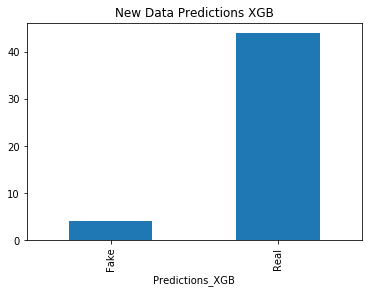

In [42]:
y = predictions_xgb.groupby(['Predictions_XGB']).size()
plt =y.plot.bar(title='New Data Predictions XGB').get_figure()
plt.savefig("new_predictions_XGB")

## Champion Model -> Logistic

### Load Model & Vectorizer

In [43]:
vectorizer_logi, model_logi = load_model_vector('../Logi/logi_model.pkl')
print(vectorizer_logi)
print()
print(model_logi)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)


### Vectorization

In [44]:
# Vectorization -> 1 = 'REVIEW_TEXT' for tfidf, countvect, ngrams and 2 = 'tokenized_text' for embedding models
text_review_logi = 'REVIEW_TEXT'

columns_dataSet_logi = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                   'word_count', 'PUNCT', 'stopwords', 'CommonWords_count',
                   'Bigrams_count', 'Trigrams_count']

vector_test_logi = feature_vector(1, df_final, text_review_logi, columns_dataSet_logi, vectorizer_logi)
vector_test_logi

<48x33252 sparse matrix of type '<class 'numpy.float64'>'
	with 1078 stored elements in Compressed Sparse Row format>

### Predicting new data

In [45]:
x_new_preds_logi = model.predict(vector_test_logi)
x_new_preds_logi

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1], dtype=int64)

In [46]:
columns_logi =['Predictions_LOGI']
index_logi =[f'{num}' for num in range(len(x_new_preds_logi))]
predictions_logi = pd.DataFrame(x_new_preds_logi, columns=columns_logi, index=index_logi)
predictions_logi.head()

,Predictions_LOGI
0,1
1,1
2,1
3,1
4,1


### Measuring Predictions

In [47]:
# Parse label to true = 1 and fake = 0
predictions_logi['Predictions_LOGI'] = predictions_logi['Predictions_LOGI'].apply(lambda x: parse_prediction(x))
predictions_logi.head()

,Predictions_LOGI
0,Real
1,Real
2,Real
3,Real
4,Real


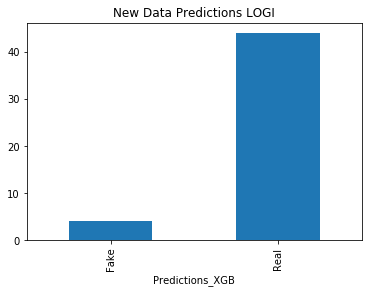

In [49]:
y_logi = predictions_logi.groupby(['Predictions_LOGI']).size()
plt_logi =y.plot.bar(title='New Data Predictions LOGI').get_figure()
plt_logi.savefig("new_predictions_LOGI")

## Predicting Deep Learning

### New Sentences Test

In [50]:
# Union texts -> fullReview
df_final["fullReview"] = df_final["ORIGINAL_PRODUCT_TITLE"] + " " +  df_final["ORIGINAL_REVIEW_TITLE"] + " " + df_final["ORIGINAL_REVIEW"]
df_final.fullReview = df_final.fullReview.astype(str)

#Apply cleaning function to each column and row of the DataFrame    
df_final['fullReview'] = df_final['fullReview'].apply(lambda x: clean_text_deep(x))

sentences_test = df_final['fullReview'].values
df_final.head()

,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,ORIGINAL_REVIEW,ORIGINAL_REVIEW_TITLE,ORIGINAL_PRODUCT_TITLE,...,subjectivity,review_len,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,tokenized_text,fullReview
0,5,1,Music,B00N1F0BKK,pain killer,five stars,purchased gift loved cd,Purchased as a gift and they loved this cd,Five Stars,Pain Killer,...,0.800000,23,4,0.0,55.6,1,3,2,"[purchased, gift, loved, cd]",pain killer five stars purchased as a gift and...
1,4,1,Music,B008OW1S3O,an awesome wave,four stars,nice,nice,Four Stars,An Awesome Wave,...,1.000000,4,1,0.0,0.0,0,0,0,[nice],an awesome wave four stars nice
2,5,1,Music,B00Q9KEZV0,tomorrow is my turn,five stars then some,rhiannon giddens one stellar voices time this ...,Rhiannon Giddens has one of the stellar voices...,FIve Stars and Then Some,Tomorrow Is My Turn,...,0.390476,132,20,3.0,45.9,4,3,17,"[rhiannon, giddens, one, stellar, voices, time...",tomorrow is my turn five stars and then some r...
3,5,1,Music,B00701QUN8,quiet riot greatest hits,five stars,excellent cd,Excellent CD&#62;,Five Stars,Quiet Riot - Greatest Hits,...,1.000000,12,2,18.8,0.0,2,0,0,"[excellent, cd]",quiet riot - greatest hits five stars excellen...
4,4,1,Music,B00AIUSGJE,meet the supremes,great recording early supremes trio,great recording early supremes trio cohesive s...,Great recording of the early Supremes when the...,Great recording of the early Supremes when the...,Meet The Supremes,...,0.530000,149,23,1.7,39.5,3,2,0,"[great, recording, early, supremes, trio, cohe...",meet the supremes great recording of the early...


### Load model

In [52]:
dl_model = load_model('../DeepLearning/deep_learning_model-6699.h5')
dl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 300)         14082600  
_________________________________________________________________
dropout (Dropout)            (None, 1500, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 375, 256)          384256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 375, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 256)           327936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 94, 256)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0

### Tokenizer

In [53]:
# Load from file
tokenizer_DL_filename = "../DeepLearning/tokenizer_DL.pickle"

with open(tokenizer_DL_filename, 'rb') as file:
    tokenizer_DL = pickle.load(file)
tokenizer_DL

In [55]:
# Transforms each text in texts to a sequence of integers.
# Only top num_words-1 most frequent words will be taken into account. 
# Only words known by the tokenizer will be taken into account.
x_test_token = tokenizer_DL.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer_DL.word_index) + 1
vocab_size

46942

### Padding

In [60]:
# Pad sequences with zeros
maxlen = 1500
x_test_DL = pad_sequences(x_test_token, padding='post', maxlen=maxlen)
x_test_DL

array([[1009, 3154,  631, ...,    0,    0,    0],
       [  60,  215, 2960, ...,    0,    0,    0],
       [5078,    7,   11, ...,    0,    0,    0],
       ...,
       [1495,    8, 1191, ...,    0,    0,    0],
       [3381,  776,  211, ...,    0,    0,    0],
       [2825, 3291, 1966, ...,    0,    0,    0]])

### Predicting new data

In [66]:
# Predict
y_pred_test_DL = (dl_model.predict(x_test_DL) > 0.5).astype("int32")
np.savetxt('prediction_test.txt', y_pred_test, fmt='%i')

# Probabilistic Prediction
y_pred_test_prob_DL = dl_model.predict(x_test_DL)
np.savetxt('prediction_test_prob.txt', y_pred_test_prob, fmt='%10.5f')
print(y_pred_test_prob_DL[:5])

[[0.28530017]
 [0.5881504 ]
 [0.49916756]
 [0.7103416 ]
 [0.93566453]]


### Measuring Predictions 

In [77]:
columns_DL =['Predictions_DL']
index_DL =[f'{num}' for num in range(len(y_pred_test_DL))]
predictions_DL = pd.DataFrame(y_pred_test_DL, columns = columns_DL, index = index_DL)
predictions_DL.head()

,Predictions_DL
0,0
1,1
2,0
3,1
4,1


In [78]:
# Parse label to true = 1 and fake = 0
predictions_DL['Predictions_DL'] = predictions_DL['Predictions_DL'].apply(lambda x: parse_prediction(x))
predictions_DL.head()

,Predictions_DL
0,Fake
1,Real
2,Fake
3,Real
4,Real


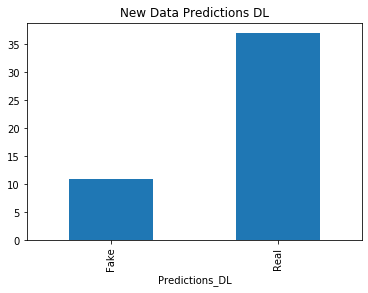

In [79]:
y_DL = predictions_DL.groupby(['Predictions_DL']).size()
plt_DL = y_DL.plot.bar(title='New Data Predictions DL').get_figure()
plt_DL.savefig("new_predictions_DL")

## Session Information

In [80]:
sinfo()

-----
cufflinks           0.17.3
emoji               0.6.0
en_core_web_sm      2.3.1
gensim              3.8.3
keras_preprocessing 1.1.0
matplotlib          3.1.3
nltk                3.4.5
numpy               1.18.1
pandas              1.1.2
pattern             3.6
plotly              4.3.0
scipy               1.4.1
seaborn             0.10.0
sinfo               0.3.1
sklearn             0.22.1
spacy               2.3.2
tabulate            0.8.7
tensorflow          1.14.0
textblob            0.15.3
xgboost             1.1.1
-----
IPython             7.13.0
jupyter_client      6.1.0
jupyter_core        4.6.1
jupyterlab          1.1.4
notebook            6.1.1
-----
Python 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
8 logical CPU cores, Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
-----
Session information updated at 2020-09-15 18:18


__Project idea:__
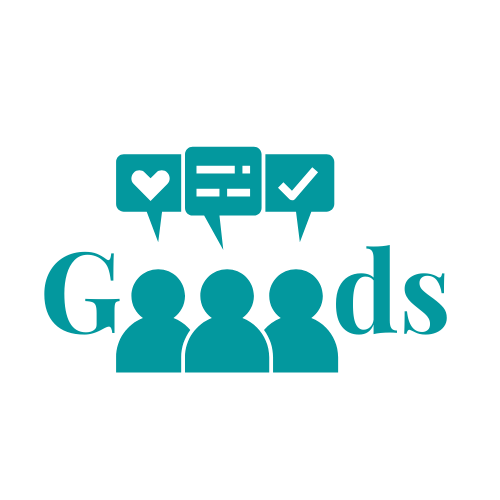


Developed by the following authors: 

 _Ainhoa Rodrigo Bolea (ainhoa2612@gmail.com)_
 
 _Alejandra Lloret Calvo (alejandralloretc@gmail.com)_
 
 _Cristian Fernando Rodríguez Saldarriaga (c.fernandoro@gmail.com)_

 _Juan Pablo Guerrero Ortiz (jguerror41@gmail.com)_ 
 
 _Laura Débora Fernández Basquero (ldfernandez09@gmail.com)_
 
 _Marta Roig Atienza (martaroigatienza@hotmail.com)_
 
 
Based on the research work: **NLP Deceitful Review Detection on e-Commerce and Social Media (2020)**

This work is part of the final master thesis to the _Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020._